### RIPE NCC RECURRING TRACEROUTE MEASUREMENT TO `eu.thethings.network`
___

In [1]:
from datetime import datetime
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import os.path
import folium

import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg

from folium import plugins
from folium.raster_layers import ImageOverlay
from palettable.colorbrewer.sequential import YlGnBu_5, YlOrBr_5,Oranges_5, Reds_5

import utilities as utils

#import sklearn
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Constants and global vars
data_dir = 'data'

## I. Data Loading and Preprocessing
<a id='data-loading'>

### I.1 Measurements

In [7]:
#probes = [13114,21673,33284]

In [8]:
json_data = utils.get_measurements(measurement_id=17468431, start='01/12/2018', stop='02/12/2018')

Fetching data from:
https://atlas.ripe.net/api/v2/measurements/17468431/results/?start=1543618800&stop=1543705200&probe_ids=None


In [9]:
# Number of records
print(str(len(json_data)) + ' results')

20902 results


In [17]:
# An exemple of result
json_data[0]

{'af': 4,
 'dst_addr': '52.169.76.255',
 'dst_name': '52.169.76.255',
 'endtime': 1543618976,
 'from': '169.0.103.214',
 'fw': 4940,
 'group_id': 17468431,
 'lts': 8,
 'msm_id': 17468431,
 'msm_name': 'Traceroute',
 'paris_id': 3,
 'prb_id': 21682,
 'proto': 'TCP',
 'result': [{'hop': 64,
   'result': [{'flags': 'SA',
     'from': '52.169.76.255',
     'hdropts': [{'mss': 1440}],
     'rtt': 176.065,
     'size': 4,
     'ttl': 50},
    {'flags': 'SA',
     'from': '52.169.76.255',
     'hdropts': [{'mss': 1440}],
     'rtt': 176.794,
     'size': 4,
     'ttl': 50},
    {'flags': 'SA',
     'from': '52.169.76.255',
     'hdropts': [{'mss': 1440}],
     'rtt': 178.843,
     'size': 4,
     'ttl': 50}]}],
 'size': 0,
 'src_addr': '192.168.3.14',
 'stored_timestamp': 1543619072,
 'timestamp': 1543618975,
 'type': 'traceroute'}

* **Measurement results data structure**

*Note that according to probe's firmware version, returned fields might differ*

From: https://atlas.ripe.net/docs/data_struct/

* `af`: adress familly with possible values: {4: IPv4, 6: IPv6}
* `dst_addr`: IP address of the destination (string)
* `dst_name`: name of the destination (string)
* `from`: IP address of the probe as known by controller (string)
* `fw`: firmware version of the probe
* `group_id`: if the measurement belongs to a group of measurements, the identifier of the group (int)
* `lts`: last time synchronised. How long ago (in seconds) the clock of the probe was found to be in sync with that of a controller. The value -1 is used to indicate that the probe does not know whether it is in sync (int)
* `msm_id`: measurement identifier (int)
* `msm_name`: measurement type "Ping" (string)
* `paris_id`: variation for the Paris mode of traceroute (int)
* `prb_id`: source probe ID (int)
* `proto`: "UDP", "ICMP", or "TCP" (string)
* `result`: list of hop elements (array of objects). Objects have the following fields:
    * `hop`: hop number (int)
    * `error`: [optional] when an error occurs trying to send a packet. In that case there will not be a result structure. (string)
    * `result`: variable content, depending on type of response (array of objects) 
objects have the following fields:
        * `flags`: "flags" -- (optional) TCP flags in the reply packet, for TCP traceroute, concatenated, in the order 'F' (FIN), 'S' (SYN), 'R' (RST), 'P' (PSH), 'A' (ACK), 'U' (URG) (fw >= 4600) (string)
        * `from`: IPv4 or IPv6 source address in reply (string)
        * `rtt`:  round-trip-time of reply, not present when the response is late in ms (float)
        * `size`: size of reply (int)
        * `ttl`: time-to-live in reply (int)
    * `size`: packet size (int)
    * `src_addr`: source address used by probe (string)
    * `timestamp`: Unix timestamp for start of measurement (int)
    * `type`: "traceroute" (string)    




* **Checking destination IP address and fetching lon, lat for later use**

In [0]:
# Let's check quickly all probes trace to the same IP address
ip_dest = set(map(lambda x: x['dst_addr'], json_data))
print('Destination IP address: ', ip_dest)

# Building the url as a long string in one go
url_ipinfo = 'http://ipinfo.io/{}?token=630bc5fdf2a21f'.format(list(ip_dest)[0])
url_ipinfo

r = requests.get(url_ipinfo)
json_ipinfo = r.json()

print(json_ipinfo)
lat_dest, lon_dest = map(lambda x: float(x), json_ipinfo['loc'].split(','))

Destination IP address:  {'52.169.76.255'}
{'ip': '52.169.76.255', 'city': 'Dublin', 'region': 'Leinster', 'country': 'IE', 'loc': '53.3331,-6.2489', 'org': 'AS8075 Microsoft Corporation', 'postal': 'D02'}


In [0]:
url_ipinfo

'http://ipinfo.io/52.169.76.255?token=630bc5fdf2a21f'

In [0]:
json_ipinfo

{'city': 'Dublin',
 'country': 'IE',
 'ip': '52.169.76.255',
 'loc': '53.3331,-6.2489',
 'org': 'AS8075 Microsoft Corporation',
 'postal': 'D02',
 'region': 'Leinster'}

In [42]:
# Utilities functions and lambdas

# Filtering/mapping Predicates
has_result = lambda row: not('error' in row['result'][0])
is_late = lambda pack: 'late' in pack
is_timed_out = lambda pack: 'x' in pack
is_error = lambda pack: 'error' in pack
is_err = lambda pack: 'err' in pack
is_empty = lambda pack: not(bool(pack))

get_result = lambda row: row['result'][0]['result']
get_nb_packets = lambda row: len(get_result(row))
get_max_nb_hops = lambda row: row['result'][0]['hop']
get_rtts = lambda row: list(filter(lambda pack: not(is_late(pack) or
                                                    is_timed_out(pack) or
                                                    is_error(pack) or 
                                                    is_err(pack) or
                                                    is_empty(pack)), get_result(row)))

get_nb_rtts = lambda row: len(get_rtts(row))
get_rtts_mean = lambda row: np.mean(list(map(lambda pack: pack['rtt'], get_rtts(row))))
get_ttl = lambda row: get_rtts(row)[0]['ttl']

to_datetime = lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

In [51]:
# Postprocess json data
measurements = []
for row in json_data:
    if has_result(row) and get_nb_rtts(row) > 0:
        measurements.append(
            {'prb_id': row['prb_id'],
             'ip_from': row['from'],
             'paris_id': row['paris_id'],
             'datetime': to_datetime(row['timestamp']),
             'start_time': row['timestamp'],
             'end_time': row['endtime'],
             'last_time_sync': row['lts'],
             'firmware_version': row['fw'],
             'nb_hops': get_max_nb_hops(row) - get_ttl(row),
             'nb_packets': get_nb_packets(row),
             'nb_rtts': get_nb_rtts(row),             
             'rtt': get_rtts_mean(row)})

In [52]:
# Convert to Pandas dataframe 
columns = ['datetime', 'prb_id', 'ip_from', 'paris_id', 'start_time', 'end_time', 
           'last_time_sync', 'firmware_version', 'nb_hops', 'nb_packets', 'nb_rtts', 'rtt']

df = pd.DataFrame(measurements, columns=columns)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

In [55]:
df.head()

,prb_id,ip_from,paris_id,start_time,end_time,last_time_sync,firmware_version,nb_hops,nb_packets,nb_rtts,rtt
datetime,,,,,,,,,,,
2018-11-30 23:02:49,35067,41.248.208.162,8,1543618969,1543618970,204,4780,17,3,3,94.480667
2018-11-30 23:02:55,21682,169.0.103.214,3,1543618975,1543618976,8,4940,14,3,3,177.234000
2018-11-30 23:03:00,33073,196.15.205.17,3,1543618980,1543618980,48,4940,14,3,3,172.731000
2018-11-30 23:03:02,50355,155.93.192.173,4,1543618982,1543618982,49,4940,14,3,3,178.559000
2018-11-30 23:03:03,11383,196.1.95.103,3,1543618983,1543618984,91,4940,17,3,3,96.144667


### I.2 Probes description
<a id='probes-description'>

#### Trying to identify ASNs for NRENs in Africa

* List of Afrian NRENs
https://www.africaconnect2.net/Partners/African_NRENs/Pages/Home.aspx
https://en.wikipedia.org/wiki/National_research_and_education_network

* Additional info: 
    * https://bgpview.io
    * UbuntuNet NRENs: https://bgpview.io/asn/36944#downstreams-v4



In [85]:
# Get list of probes involved in measurements
probes_id = list(df['prb_id'].unique())

In [86]:
json_data_probe = utils.get_probes(probes_id)

In [87]:
# An example of probe's description.
json_data_probe['results'][0]

{'address_v4': '196.1.95.16',
 'address_v6': '2001:4278:1000:1::16',
 'asn_v4': 8346,
 'asn_v6': 8346,
 'country_code': 'SN',
 'description': 'UCAD Probe',
 'first_connected': 1291147153,
 'geometry': {'type': 'Point', 'coordinates': [-17.4415, 14.6715]},
 'id': 239,
 'is_anchor': False,
 'is_public': True,
 'last_connected': 1566556239,
 'prefix_v4': '196.1.92.0/22',
 'prefix_v6': '2001:4278::/32',
 'status': {'id': 1, 'name': 'Connected', 'since': '2019-08-18T18:45:22Z'},
 'status_since': 1566153922,
 'tags': [{'name': 'Office', 'slug': 'office'},
  {'name': 'No NAT', 'slug': 'no-nat'},
  {'name': 'system: V1', 'slug': 'system-v1'},
  {'name': 'system: Resolves A Correctly',
   'slug': 'system-resolves-a-correctly'},
  {'name': 'system: Resolves AAAA Correctly',
   'slug': 'system-resolves-aaaa-correctly'},
  {'name': 'system: IPv4 Works', 'slug': 'system-ipv4-works'},
  {'name': "system: IPv6 Doesn't Work", 'slug': 'system-ipv6-doesnt-work'},
  {'name': 'system: IPv4 Capable', 'slug

In [88]:
# Postprocess json data
probes = []
for i, row in enumerate(json_data_probe['results']):
        probes.append(
            {'prb_id': row['id'],
             'ip_v4': row['address_v4'],
             'asn': str(row['asn_v4']),
             'country_code': row['country_code'],
             'description': row['description'],
             'lon': row['geometry']['coordinates'][0],
             'lat': row['geometry']['coordinates'][1]})

In [89]:
# Convert to Pandas dataframe 
columns = ['prb_id','ip_v4', 'asn', 'country_code', 'description', 'lon', 'lat']
df_probes = pd.DataFrame(probes, columns=columns)

In [90]:
print('Number of countries: ', len(df_probes['country_code'].unique()))
print(df_probes['country_code'].unique())

Number of countries:  35
['SN' 'ZA' 'MU' 'TN' 'BW' 'CM' 'GH' 'TZ' 'UG' 'CG' 'BJ' 'NG' 'MA' 'BI'
 'KE' 'MZ' 'ET' 'ZM' 'SZ' 'AO' 'MW' 'LS' 'NA' 'MG' 'SD' 'SS' 'SC' 'CD'
 'DZ' 'ZW' 'GM' 'TG' 'RW' 'EG' 'DJ']


In [91]:
# Loading country codes
country_codes = pd.read_csv('https://raw.githubusercontent.com/franckalbinet/' + 
                            'latency-internet-africa/master/data/country_codes.csv')

country_codes.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [92]:
# Joining/merging with country code to get full country name
df_probes = pd.merge(df_probes, country_codes[['name', 'alpha-2']], left_on='country_code', 
                     right_on='alpha-2', how='left')
df_probes = df_probes.drop(['country_code'], axis=1)
df_probes.rename(columns={'alpha-2':'country_code', 'name': 'country_name'}, inplace=True)
df_probes.head()

,prb_id,ip_v4,asn,description,lon,lat,country_name,country_code
0,239,196.1.95.16,8346,UCAD Probe,-17.4415,14.6715,Senegal,SN
1,242,None,328453,1 Belvedere,18.4895,-33.9815,South Africa,ZA
2,446,196.192.112.229,37708,AFRINIC Mauritius,57.4995,-20.2395,Mauritius,MU
3,473,196.4.161.3,3741,Internet Solutions [http://www.is.co.za] - Ros...,28.0405,-26.1515,South Africa,ZA
4,567,193.95.66.40,2609,"ATI, BELVEDERE, 1G/s",10.1805,36.8205,Tunisia,TN


* **It looks like we don't get the IP address from all probes. Let's use the ip address provided in measurement results instead.**

In [93]:
# Note that each probe can have several IP addresses. We keep only one.
ip_from_measurement = df[['prb_id','ip_from']].reset_index().drop(columns=['datetime']).drop_duplicates(subset='prb_id')

In [94]:
df_probes = pd.merge(df_probes, ip_from_measurement, left_on='prb_id', right_on='prb_id', how='left') 

In [95]:
df_probes.head()

,prb_id,ip_v4,asn,description,lon,lat,country_name,country_code,ip_from
0,239,196.1.95.16,8346,UCAD Probe,-17.4415,14.6715,Senegal,SN,196.1.95.16
1,242,None,328453,1 Belvedere,18.4895,-33.9815,South Africa,ZA,196.210.11.182
2,446,196.192.112.229,37708,AFRINIC Mauritius,57.4995,-20.2395,Mauritius,MU,196.192.112.229
3,473,196.4.161.3,3741,Internet Solutions [http://www.is.co.za] - Ros...,28.0405,-26.1515,South Africa,ZA,196.4.161.3
4,567,193.95.66.40,2609,"ATI, BELVEDERE, 1G/s",10.1805,36.8205,Tunisia,TN,193.95.66.40


In [96]:
ipinfo_lookup = []
for ip in df_probes['ip_from'].values:
  r = requests.get('http://ipinfo.io/{}?token=your-token'.format(ip))
  ipinfo_lookup.append(r.json())

In [97]:
df_ip_info = pd.DataFrame(ipinfo_lookup)
df_ip_info.head()

,city,country,hostname,ip,loc,org,postal,region
0,,SN,dkr-sn.probe.atlas.ucad.sn,196.1.95.16,"14.0000,-14.0000",AS8346 SONATEL-AS Autonomous System,NaN,
1,Cape Town,ZA,196-210-11-182.dynamic.isadsl.co.za,196.210.11.182,"-33.9258,18.4232",AS3741 Internet Solutions,7945,Western Cape
2,,MU,p446.probes.atlas.ripe.net,196.192.112.229,"-20.2833,57.5500",AS37708 African Network Information Center - (...,NaN,
3,,ZA,ripe-ncc.is.co.za,196.4.161.3,"-29.0000,24.0000",AS3741 Internet Solutions,NaN,
4,Tunis,TN,NaN,193.95.66.40,"36.8190,10.1658",AS2609 Tunisia BackBone AS,NaN,Tūnis


In [98]:
df_probes = pd.merge(df_probes, df_ip_info, left_on='ip_from', right_on='ip', how='left') 
df_probes.head()

,prb_id,ip_v4,asn,description,lon,lat,country_name,country_code,ip_from,city,country,hostname,ip,loc,org,postal,region
0,239,196.1.95.16,8346,UCAD Probe,-17.4415,14.6715,Senegal,SN,196.1.95.16,,SN,dkr-sn.probe.atlas.ucad.sn,196.1.95.16,"14.0000,-14.0000",AS8346 SONATEL-AS Autonomous System,NaN,
1,242,None,328453,1 Belvedere,18.4895,-33.9815,South Africa,ZA,196.210.11.182,Cape Town,ZA,196-210-11-182.dynamic.isadsl.co.za,196.210.11.182,"-33.9258,18.4232",AS3741 Internet Solutions,7945,Western Cape
2,446,196.192.112.229,37708,AFRINIC Mauritius,57.4995,-20.2395,Mauritius,MU,196.192.112.229,,MU,p446.probes.atlas.ripe.net,196.192.112.229,"-20.2833,57.5500",AS37708 African Network Information Center - (...,NaN,
3,473,196.4.161.3,3741,Internet Solutions [http://www.is.co.za] - Ros...,28.0405,-26.1515,South Africa,ZA,196.4.161.3,,ZA,ripe-ncc.is.co.za,196.4.161.3,"-29.0000,24.0000",AS3741 Internet Solutions,NaN,
4,567,193.95.66.40,2609,"ATI, BELVEDERE, 1G/s",10.1805,36.8205,Tunisia,TN,193.95.66.40,Tunis,TN,NaN,193.95.66.40,"36.8190,10.1658",AS2609 Tunisia BackBone AS,NaN,Tūnis


In [99]:
df_probes = df_probes[['prb_id', 'ip', 'asn', 'hostname', 'org', 'description', 'country_name', 'country_code', 'region', 'city', 'lon', 'lat']]

In [100]:
df_probes.head()

,prb_id,ip,asn,hostname,org,description,country_name,country_code,region,city,lon,lat
0,239,196.1.95.16,8346,dkr-sn.probe.atlas.ucad.sn,AS8346 SONATEL-AS Autonomous System,UCAD Probe,Senegal,SN,,,-17.4415,14.6715
1,242,196.210.11.182,328453,196-210-11-182.dynamic.isadsl.co.za,AS3741 Internet Solutions,1 Belvedere,South Africa,ZA,Western Cape,Cape Town,18.4895,-33.9815
2,446,196.192.112.229,37708,p446.probes.atlas.ripe.net,AS37708 African Network Information Center - (...,AFRINIC Mauritius,Mauritius,MU,,,57.4995,-20.2395
3,473,196.4.161.3,3741,ripe-ncc.is.co.za,AS3741 Internet Solutions,Internet Solutions [http://www.is.co.za] - Ros...,South Africa,ZA,,,28.0405,-26.1515
4,567,193.95.66.40,2609,NaN,AS2609 Tunisia BackBone AS,"ATI, BELVEDERE, 1G/s",Tunisia,TN,Tūnis,Tunis,10.1805,36.8205


In [101]:
# Saving probes description as csv
utils.df_to_csv(df_probes, prefix_name='probes')

### I.3 Merging measurements and probes
<a id='merge-measurements-probes'>

In [0]:
# Joining/merging with country code to get full country name
data = pd.merge(df.reset_index(), df_probes, left_on='prb_id', right_on='prb_id', how='left')

In [0]:
data.head(10)

,datetime,prb_id,start_time,end_time,last_time_sync,firmware_version,nb_packets,nb_rtts,rtt,ip_v4,description,lon,lat,country_name,country_code
0,2018-12-01 00:02:48,35067,1543622568,1543622568,206,4780,3,3,92.663667,41.249.120.100,Rue Bruxelles,-6.2395,33.8205,Morocco,MA
1,2018-12-01 00:02:52,27571,1543622572,1543622572,57,4940,3,3,172.185667,45.222.33.70,BennieJ Home,28.1405,-25.8125,South Africa,ZA
2,2018-12-01 00:02:55,21682,1543622575,1543622575,49,4940,3,3,175.827000,None,Strand,18.8315,-34.1015,South Africa,ZA
3,2018-12-01 00:03:00,12286,1543622580,1543622581,37,4760,3,3,169.836667,None,eNetworks Samrand,28.1415,-25.9295,South Africa,ZA
4,2018-12-01 00:03:01,13810,1543622581,1543622582,60,4940,3,3,179.662333,197.96.8.2,Internet Solutions [http://www.is.co.za] - Mas...,28.2275,-29.6125,Lesotho,LS
5,2018-12-01 00:03:01,10243,1543622581,1543622581,20,4940,3,3,151.962667,41.221.32.130,SimbaNET TZ,39.2795,-6.7915,"Tanzania, United Republic of",TZ
6,2018-12-01 00:03:03,11383,1543622583,1543622584,45,4940,3,3,94.094000,196.1.95.103,UCAD-NG-Probe,-17.3685,14.7585,Senegal,SN
7,2018-12-01 00:03:04,33073,1543622584,1543622585,49,4940,3,3,171.836333,196.15.205.17,SecundaSpar,29.1905,-26.5215,South Africa,ZA
8,2018-12-01 00:03:04,50355,1543622584,1543622584,53,4940,3,3,177.840333,155.93.192.242,Cool Ideas FTTH client,30.8295,-29.7805,South Africa,ZA
9,2018-12-01 00:03:10,22252,1543622590,1543622591,71,4940,3,3,184.301667,41.72.136.130,Hetzner Africa - Johannesburg,28.1395,-25.9315,South Africa,ZA


In [0]:
# Saving build data frame as csv for later re-use
#base_filename = 'data-dump-' + datetime.now().strftime('%Y-%m-%d')
#data.to_csv(os.path.join(data_dir, base_filename + '.csv'), index=False)

## II. Exploratory Data Analysis (EDA)
<a id='data-loading'>

In [0]:
# How many measurements and columns
data.shape

(606940, 15)

In [0]:
# Quick descriptive statistics
data['rtt'].describe()

count    564253.000000
mean        165.532495
std         125.118821
min           0.483333
25%         130.974333
50%         169.441333
75%         183.322000
max        6292.648333
Name: rtt, dtype: float64

### II.1 Round Trip Time overall histogram 
<a id='overall-histogram'>

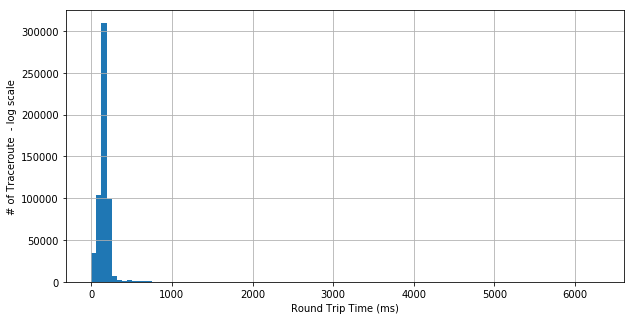

In [0]:
# Quick histogram of 'rtt'
fig, ax = plt.subplots()
data['rtt'].hist(ax=ax, bins=100, bottom=0.1, figsize=(10, 5))
#ax.set_yscale('log')
ax.set_xlabel('Round Trip Time (ms)');
ax.set_ylabel('# of Traceroute  - log scale');

### II.2 Boxplots of Round-Trip-Time (RTT) by country
<a id='boxplot-by-country'>

In [0]:
def get_sorted_group_vals(df, grp_col, val_col, sort_by='median', ascending=False, ):
    """
    Transform a dataframe into a new one with group name as column and values as rows sorted by specified statistic (default median)

    Parameters
    ----------
    df : dataframe to transform
    grp_col : name of the column to group by (str)
    val_col : name of the column containing values (str)
    sort_by = median, mean, ... 
    ascending: sorting order (bool)
    """
    group = df.groupby([grp_col])
    df_group = pd.DataFrame({col: vals[val_col] for col,vals in group})
    meds = getattr(df_group, sort_by)()
    meds = meds.sort_values(ascending=False)
    return df_group[meds.index]

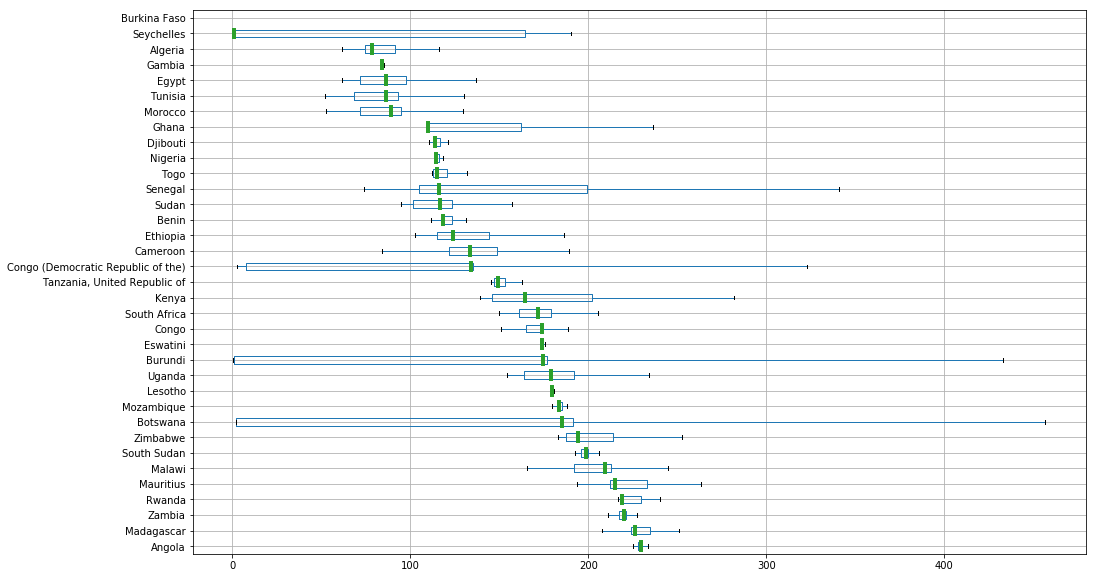

In [0]:
# Quick boxplots by country ["outliers" not displayed - showfliers=False]
#     - sorted by rtt's median
df_rtt_country = data[['rtt', 'country_name']]
df_rtt_by_country = get_sorted_group_vals(df=df_rtt_country, grp_col='country_name', val_col='rtt')

medianprops = dict(linestyle='-', linewidth=4)
df_rtt_by_country.boxplot(vert=False, figsize=(16, 10), showfliers=False, medianprops=medianprops);

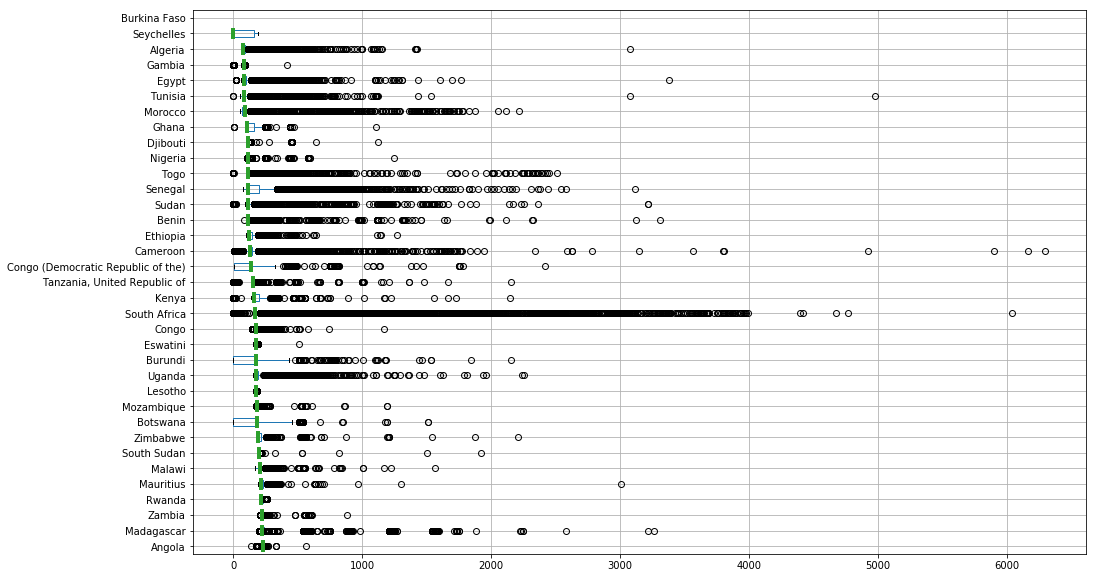

In [0]:
# With outliers displayed
medianprops = dict(linestyle='-', linewidth=4)
df_rtt_by_country.boxplot(vert=False, figsize=(16, 10), showfliers=True, medianprops=medianprops);

### II.3 Percentage of RTT outliers by country
<a id='outliers-by-country'></a>

Outliers characterization using the simple rule of thumb: 

* Is outlier whatever is **higher** than `Q3 + 1.5 * (Q3 - Q1)` with `Q3` and `Q1` respectively the third and first quartile.

In [0]:
def describe_outliers(series):
    q1, median, q3 = series.quantile(q=[.25, .5, .75])
    iqr = q3 - q1
    percent_outliers = np.round(100*np.sum(series > 1.5*iqr + q3)/len(series), 2)
    return pd.Series({'q1': q1, 'median': median, 'q3': q3, 'iqr': iqr,
                      'percent_outliers': percent_outliers})

data.dropna(subset=['rtt'])\
    .groupby('country_name')['rtt']\
    .apply(describe_outliers)\
    .unstack()\
    .sort_values(by='percent_outliers', ascending=False)

,q1,median,q3,iqr,percent_outliers
country_name,,,,,
Togo,112.976917,115.077500,120.474833,7.497917,23.00
Nigeria,114.230333,114.422000,115.975500,1.745167,22.34
Mozambique,182.784667,183.784667,184.988667,2.204000,18.10
"Tanzania, United Republic of",146.896667,149.472333,153.363167,6.466500,17.20
Mauritius,212.384250,215.176500,232.840833,20.456583,16.74
Egypt,71.613833,86.084500,97.820000,26.206167,13.82
Benin,117.818000,118.161333,123.266000,5.448000,13.78
Zambia,217.323667,219.807333,221.457333,4.133667,10.28
Sudan,101.222000,116.574000,123.577583,22.355583,10.22


### II.4 How many probes and measurements per country?
<a id='nb-probes-measurements-per-country'>

In [0]:
data.groupby('country_name')[['prb_id', 'rtt']]\
    .agg({'prb_id':'nunique', 'rtt':'count'})\
    .sort_values(by='prb_id', ascending=False)\
    .rename(columns={'prb_id': 'nb_of_probes', 'rtt': 'nb_of_measurements'})

,nb_of_probes,nb_of_measurements
country_name,,
South Africa,91,235996
Kenya,13,33892
Tunisia,9,19946
Benin,7,19429
Uganda,7,13022
Cameroon,7,15412
"Tanzania, United Republic of",7,17211
Togo,6,14540
Senegal,6,16736


### II.5 Spatializing probes location and RTT
<a id='maps'>

In [0]:
# Retrieve probes location
probes_loc = data.drop_duplicates(subset=['prb_id'])[['prb_id', 'description', 'lon', 'lat']]
probes_loc.head()

,prb_id,description,lon,lat
0,35067,Rue Bruxelles,-6.2395,33.8205
1,27571,BennieJ Home,28.1405,-25.8125
2,21682,Strand,18.8315,-34.1015
3,12286,eNetworks Samrand,28.1415,-25.9295
4,13810,Internet Solutions [http://www.is.co.za] - Mas...,28.2275,-29.6125


#### II.5.1 Probes location
<a id='probes-location'>

In [0]:
# Instantiate a folium map object
m = folium.Map([5, 20], tiles='Mapbox Bright', zoom_start=3)

# mark each station as a point
for index, row in probes_loc.iterrows():
    folium.Marker([row['lat'], row['lon']],
                        #radius=5,
                        popup=row['description'],
                        icon=folium.Icon(color='darkred', icon='info-sign')
                       ).add_to(m)
m

#### II.5.2 Probes location heat map
<a id='probes-location-heatmap'></a>

*Preliminary remark: This kind of visualization might be somewhat misleading as visual effect extremely sensitive to the vis. parameters. However, it highlights that most probes are located in South, West and North Africa.*

In [0]:
# Probes locations Heatmap (density of probes)

# Instantiate a folium map object
#m = folium.Map([5, 20], tiles='Mapbox Control Room', zoom_start=3)
m = folium.Map([5, 20], tiles='cartodbdark_matter', zoom_start=3)

# convert to (n, 2) nd-array format for heatmap
probesArr = probes_loc[['lat', 'lon']].as_matrix()

# plot heatmap
m.add_children(plugins.HeatMap(probesArr, radius=10, 
                               blur=10,
                               min_opacity=0.8,
                               gradient={0.3: '#110e8f', 0.8: '#cc4e74', 1: '#f2f800'}))
m

#### II.5.3 Hexbin RTT median
<a id='hexbin-rtt-median'>

// To be fixed: hexagons looks shifted on the right -- as unprojected - map projection (most probably Google Mercator required)

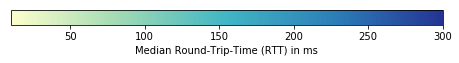

In [0]:
# Median RTT aggregated - hexbin map
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

hb = ax.hexbin(data.lon, data.lat, C = df.rtt, 
           reduce_C_function = np.median, gridsize=30, 
           mincnt=0, cmap=YlGnBu_5.get_mpl_colormap(), 
           linewidths=0.5, edgecolors='none')

ax.set_axis_off()

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

plt.savefig('rtt-median.png', transparent=True, pad_inches=0, bbox_inches='tight', dpi=300)
plt.close(fig) # do not display default hexbin

# Plot legend
# https://matplotlib.org/examples/api/colorbar_only.html
fig = plt.figure(figsize=(6, 2))
ax1 = fig.add_axes([0, 0, 1, 0.1])
cmap = hb.cmap
norm = mpl.colors.Normalize(vmin=10, vmax=300)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal')

cb1.set_label('Median Round-Trip-Time (RTT) in ms')

# Save as png and overlay on folium map
data_overlay = plt.imread('rtt-median.png')

m = folium.Map([5, 20], tiles='cartodbpositron', zoom_start=3, control_scale=True)

m.add_child(ImageOverlay(data_overlay, opacity=0.8, \
        bounds =[[ymin, xmin], [ymax, xmax]]))

m

### II.6 Assessing RTT variability by probe and firmware
<a id='rtt-variation-probe-firmware'>

In [0]:
# RTTs Standard Deviation by probe
data.dropna(subset=['rtt'])\
    .groupby('prb_id')['rtt']\
    .agg('std')\
    .sort_values(ascending=False)

prb_id
35743    941.519535
2456     399.435737
35067    263.944003
30033    259.873705
23531    236.346965
21632    228.583824
28493    222.289882
21770    213.473528
21715    195.367829
32381    189.326322
19592    184.517663
4519     181.347457
14712    180.457141
11383    178.688472
32206    176.288848
239      175.945578
21610    156.239397
50011    150.248411
30145    145.066153
21682    141.897949
4153     138.381247
15269    136.998219
33838    134.303803
12168    129.583220
22588    121.188746
3461     120.901329
10843    120.130631
14867    118.590701
14419    112.082882
19984    108.980009
            ...    
13734      3.803250
13705      3.793669
35742      3.719424
21673      3.545849
29857      3.104209
25355      2.888534
33126      2.881804
50139      2.864981
20772      2.759435
11327      2.621536
13725      2.508494
33289      2.507391
12207      2.298269
30021      2.263489
35736      2.026521
32258      1.992480
12286      1.974966
33105      1.910403
13236      1.

In [0]:
# RTTs Standard Deviation by probes' firmware version
data.dropna(subset=['rtt'])\
    .groupby('firmware_version')['rtt']\
    .agg('std')\
    .sort_values(ascending=False)

firmware_version
4650    195.367829
4790    136.248082
4780    127.046378
4940    126.085855
4760    116.196127
4770     74.396395
4900     52.327388
4910     14.542528
Name: rtt, dtype: float64

In [0]:
# List of different firmware version used by country and associated number of measurements carried out
data.dropna(subset=['rtt'])\
    .groupby(['country_name', 'firmware_version'])['rtt']\
    .agg('count')

country_name                        firmware_version
Algeria                             4780                  2854
                                    4940                  8074
Angola                              4940                  4562
Benin                               4760                  2753
                                    4770                  2874
                                    4900                   418
                                    4940                 13384
Botswana                            4790                  2879
                                    4940                  5760
Burundi                             4940                  5112
Cameroon                            4650                  2158
                                    4770                  2738
                                    4790                  1451
                                    4940                  9065
Congo                               4940                  2876
Co

### II.7 Packet loss analysis

In [0]:
data.head(1)

,datetime,prb_id,start_time,end_time,last_time_sync,firmware_version,nb_packets,nb_rtts,rtt,ip_v4,description,lon,lat,country_name,country_code
0,2018-12-01 00:02:48,35067,1543622568,1543622568,206,4780,3,3,92.663667,105.158.149.25,Rue Bruxelles,-6.2395,33.8205,Morocco,MA


* `nb_packets`: number of packets sent
* `nb_rtts`: nb. of successfully sent packets out of total sent

In [0]:
# Adding packet loss percentage column
data['packet_loss_percent'] = 100 * (data['nb_packets'] - data['nb_rtts']) / data['nb_packets']

In [0]:
data.head()

,datetime,prb_id,start_time,end_time,last_time_sync,firmware_version,nb_packets,nb_rtts,rtt,ip_v4,description,lon,lat,country_name,country_code,packet_loss_percent
0,2018-12-01 00:02:48,35067,1543622568,1543622568,206,4780,3,3,92.663667,105.158.149.25,Rue Bruxelles,-6.2395,33.8205,Morocco,MA,0.0
1,2018-12-01 00:02:52,27571,1543622572,1543622572,57,4940,3,3,172.185667,45.222.33.70,BennieJ Home,28.1405,-25.8125,South Africa,ZA,0.0
2,2018-12-01 00:02:55,21682,1543622575,1543622575,49,4940,3,3,175.827000,None,Strand,18.8315,-34.1015,South Africa,ZA,0.0
3,2018-12-01 00:03:00,12286,1543622580,1543622581,37,4760,3,3,169.836667,None,eNetworks Samrand,28.1415,-25.9295,South Africa,ZA,0.0
4,2018-12-01 00:03:01,13810,1543622581,1543622582,60,4940,3,3,179.662333,197.96.8.2,Internet Solutions [http://www.is.co.za] - Mas...,28.2275,-29.6125,Lesotho,LS,0.0


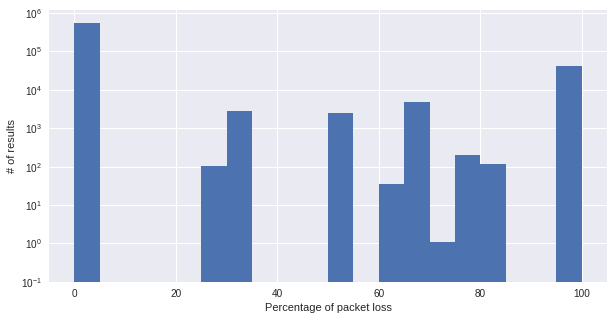

In [0]:
# Quick histogram of 'packet'
fig, ax = plt.subplots()
data['packet_loss_percent'].hist(ax=ax, bins=20, bottom=0.1, figsize=(10, 5))
ax.set_yscale('log')
ax.set_xlabel('Percentage of packet loss');
ax.set_ylabel('# of results');

In [0]:
# Percentage Packet loss by country
data.groupby('country_name')[['packet_loss_percent', 'rtt', 'prb_id']]\
    .agg({'packet_loss_percent':'mean', 'rtt':'count', 'prb_id': 'nunique'})\
    .sort_values(by='packet_loss_percent', ascending=False)\
    .rename(columns={'packet_loss_percent': '% packet loss mean', 'rtt': 'nb_of_measurements', 'prb_id': '# of probes deployed'})

,% packet loss mean,nb_of_measurements,# of probes deployed
country_name,,,
Burkina Faso,100.000000,0,1
Rwanda,51.582901,2707,2
Ghana,25.064398,8633,4
Nigeria,25.020255,8638,4
Congo (Democratic Republic of the),24.069479,5607,2
Uganda,21.598357,13022,7
Mauritius,20.486284,11180,5
"Tanzania, United Republic of",14.506157,17211,7
Tunisia,13.076688,19946,9


### II.8 Boxplots of RTT by hour of the day

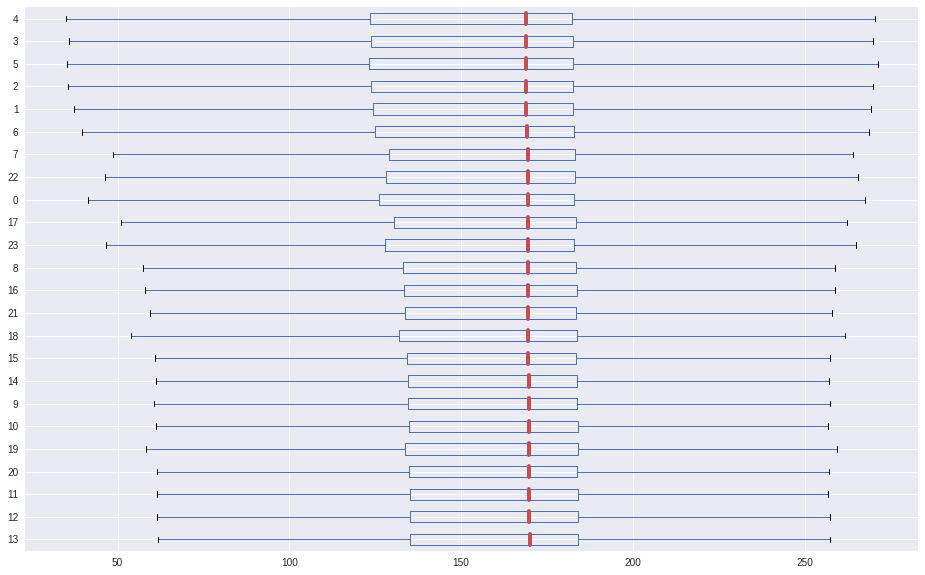

In [0]:
df_hour_rtt = pd.concat([data.datetime.apply(lambda x: x.hour), data['rtt']], axis=1)
df_hour_rtt.columns = ['hour', 'rtt']
df_rtt_by_hour = get_sorted_group_vals(df=df_hour_rtt, grp_col='hour', val_col='rtt')

medianprops = dict(linestyle='-', linewidth=4)
df_rtt_by_hour.boxplot(vert=False, figsize=(16, 10), showfliers=False, medianprops=medianprops);

### II.9 Boxplots of RTT by day of the week

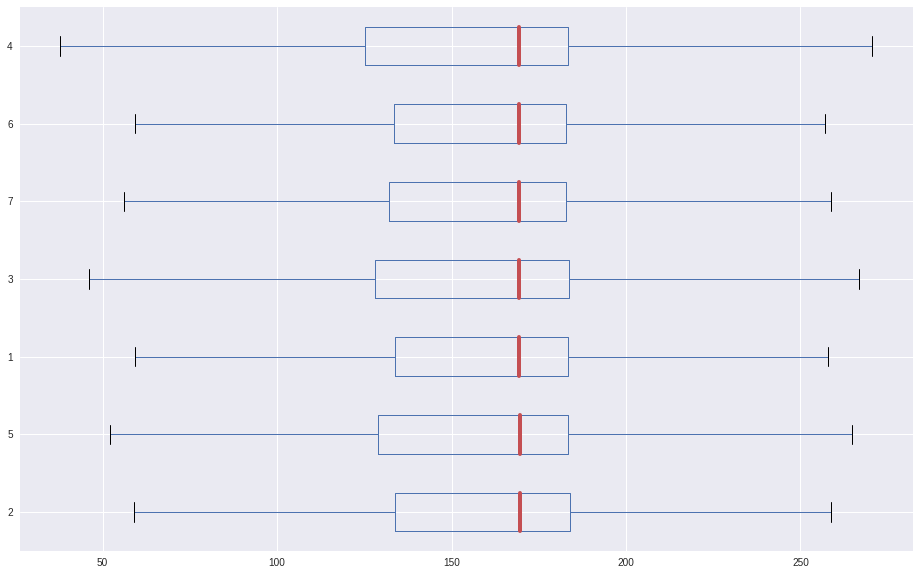

In [0]:
df_weekday_rtt = pd.concat([data.datetime.apply(lambda x: x.isoweekday()), data['rtt']], axis=1)
df_weekday_rtt.columns = ['weekday', 'rtt']
df_rtt_by_weekday = get_sorted_group_vals(df=df_weekday_rtt, grp_col='weekday', val_col='rtt')

medianprops = dict(linestyle='-', linewidth=4)
df_rtt_by_weekday.boxplot(vert=False, figsize=(16, 10), showfliers=False, medianprops=medianprops);

### II.10 RTTs vs distance to destination

In [0]:
# Let's take a sample of our data for now
sample_size = 50000
data_sample = data.sample(n=sample_size, random_state=1)

In [0]:
# Converting to geopandas dataframe
data_sample['coordinates'] = list(zip(data_sample.lon, data_sample.lat))
data_sample['coordinates'] = data_sample['coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(data_sample, geometry='coordinates')
gdf.crs = {'init' :'epsg:4326'} 
gdf.head()

,datetime,prb_id,start_time,end_time,last_time_sync,firmware_version,nb_packets,nb_rtts,rtt,ip_v4,description,lon,lat,country_name,country_code,packet_loss_percent,coordinates
280769,2018-12-14 15:36:33,24798,1544801793,1544801793,69,4940,3,3,146.508000,196.49.5.74,Astrium TISPA Office,39.2115,-6.7885,"Tanzania, United Republic of",TZ,0.000000,POINT (39.2115 -6.7885)
540020,2018-12-27 14:07:00,50322,1545919620,1545919620,40,4940,3,3,182.638333,155.93.219.254,Atlas1,31.0785,-29.7215,South Africa,ZA,0.000000,POINT (31.0785 -29.7215)
178827,2018-12-09 17:21:55,14968,1544376115,1544376115,18,4940,3,3,182.977667,63.223.6.90,PCCW Global - atl01.mpm02 - MZ,32.5705,-25.9685,Mozambique,MZ,0.000000,POINT (32.5705 -25.9685)
239444,2018-12-12 15:37:14,14465,1544629034,1544629035,9,4940,3,3,215.902333,196.216.164.50,Namibia University of Science and Technology,17.0805,-22.5705,NaN,NaN,0.000000,POINT (17.0805 -22.5705)
452020,2018-12-23 03:33:25,22215,1545536005,1545536009,9,4940,3,2,142.938500,160.119.216.205,icolo.io MBA1,39.5875,-4.0105,Kenya,KE,33.333333,POINT (39.5875 -4.0105)


To be able to calculate distance on a sphere, we need to use a World Equidistant Cylindrical map projection that must be centered in our IP destination location.

In [0]:
# Projection parameters (centered on our point of interest)
proj4_txt = ('+proj=eqc +lat_ts=60 +lat_0={} '
             '+lon_0={} +x_0=0 +y_0=0 +ellps=WGS84 '
             '+datum=WGS84 +units=m +no_defs').format(lat_dest, lon_dest)

In [0]:
# Reprojecting to World Equidistant Cylindrical (coordinates will be expressed in meters from now)
gdf_proj = gdf.to_crs(proj4_txt) 

In [0]:
# Creating a point object for destination point
destination_location_df = gpd.GeoSeries([Point(lon_dest, lat_dest)], crs=from_epsg(4326))

# And reprojecting
destination_location_df = destination_location_df.to_crs(proj4_txt)

In [0]:
def calculateDistance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between a single Shapely Point geometry and a GeoDataFrame with Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
        A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
        A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
        A name of the target column where the result will be stored.
    """
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)
    # Tranform into kilometers
    dist_km = int(dist/1000)
    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

In [0]:
# Getting poi geometry
destination_location_df_geom = destination_location_df.get(0)

# Calculating the distance and adding a new column
gdf_proj = gdf_proj.apply(calculateDistance, dest_geom=destination_location_df_geom,
                                        src_col='coordinates', target_col='dist_to_dest', axis=1)

In [0]:
# Let's check our new 'dist_to_dest' column
gdf_proj[['prb_id', 'country_name', 'description', 'dist_to_dest']].head()

,prb_id,country_name,description,dist_to_dest
280769,24798,"Tanzania, United Republic of",Astrium TISPA Office,7156
540020,50322,South Africa,Atlas1,9477
178827,14968,Mozambique,PCCW Global - atl01.mpm02 - MZ,9089
239444,14465,NaN,Namibia University of Science and Technology,8550
452020,22215,Kenya,icolo.io MBA1,6875


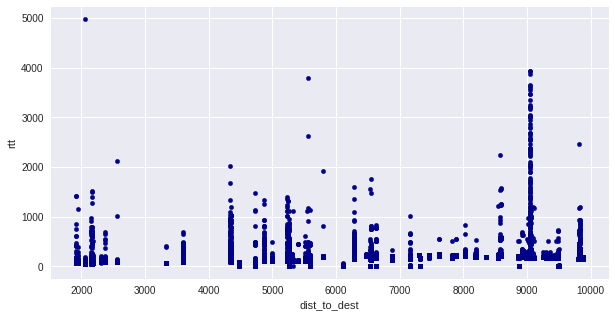

In [0]:
# Scatter plot of rtt vs distance to destination
df_dist_rtt = pd.DataFrame(gdf_proj)[['dist_to_dest', 'rtt']]
df_dist_rtt.plot.scatter(x='dist_to_dest', y='rtt', c='DarkBlue');

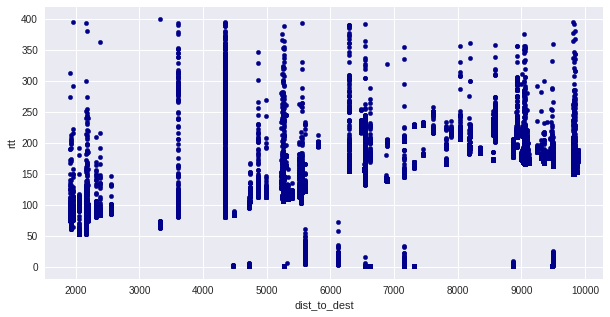

In [0]:
# Scatter plot of rtt vs distance to destination (zoomed on rtt < 400)
df_dist_rtt[df_dist_rtt['rtt'] < 400].plot.scatter(x='dist_to_dest', y='rtt', c='DarkBlue');

In [0]:
# Correlation between rtt and distance to dest
df_dist_rtt.corr()

,dist_to_dest,rtt
dist_to_dest,1.000000,0.193514
rtt,0.193514,1.000000


### II.11 RTTs vs percentage of packet loss

In [0]:
gdf_proj['packet_loss_percent'] = 100 * (gdf['nb_packets'] - gdf['nb_rtts']) / gdf['nb_packets']

In [0]:
gdf_proj.head()

,datetime,prb_id,start_time,end_time,last_time_sync,firmware_version,nb_packets,nb_rtts,rtt,ip_v4,description,lon,lat,country_name,country_code,packet_loss_percent,coordinates,dist_to_dest
280769,2018-12-14 15:36:33,24798,1544801793,1544801793,69,4940,3,3,146.508000,196.49.5.74,Astrium TISPA Office,39.2115,-6.7885,"Tanzania, United Republic of",TZ,0.000000,POINT (2531254.939326471 -6694019.467668236),7156
540020,2018-12-27 14:07:00,50322,1545919620,1545919620,40,4940,3,3,182.638333,155.93.219.254,Atlas1,31.0785,-29.7215,South Africa,ZA,0.000000,POINT (2078574.230015623 -9246909.350030379),9477
178827,2018-12-09 17:21:55,14968,1544376115,1544376115,18,4940,3,3,182.977667,63.223.6.90,PCCW Global - atl01.mpm02 - MZ,32.5705,-25.9685,Mozambique,MZ,0.000000,POINT (2161618.570147406 -8829127.301083224),9089
239444,2018-12-12 15:37:14,14465,1544629034,1544629035,9,4940,3,3,215.902333,196.216.164.50,Namibia University of Science and Technology,17.0805,-22.5705,NaN,NaN,0.000000,POINT (1299449.113953502 -8450863.671367681),8550
452020,2018-12-23 03:33:25,22215,1545536005,1545536009,9,4940,3,2,142.938500,160.119.216.205,icolo.io MBA1,39.5875,-4.0105,Kenya,KE,33.333333,POINT (2552183.003595606 -6384773.922244523),6875


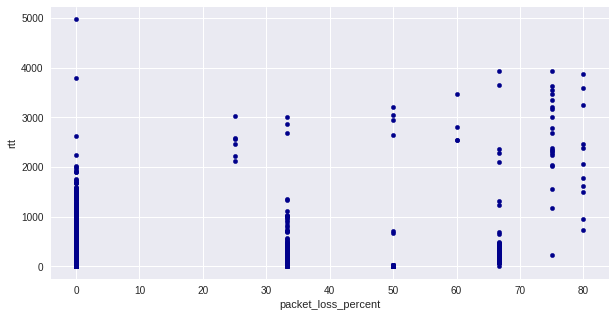

In [0]:
# Scatter plot of rtt vs percentage loss
df_loss_rtt = pd.DataFrame(gdf_proj)[['packet_loss_percent', 'rtt']]
df_loss_rtt.plot.scatter(x='packet_loss_percent', y='rtt', c='DarkBlue');

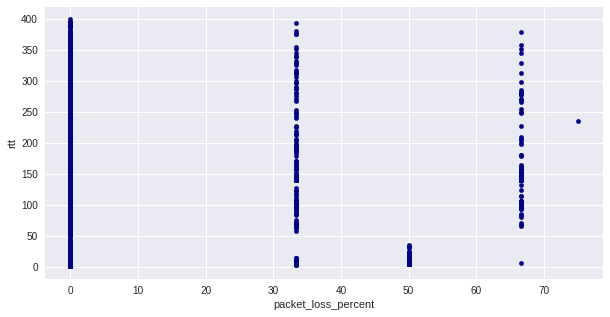

In [0]:
# Scatter plot of rtt vs percentage loss [zoom where rtt<400]
df_loss_rtt[df_loss_rtt['rtt']<400].plot.scatter(x='packet_loss_percent', y='rtt', c='DarkBlue');

In [0]:
# Correlation between rtt and packet loss percentage 
df_loss_rtt.corr()

,packet_loss_percent,rtt
packet_loss_percent,1.000000,0.155878
rtt,0.155878,1.000000
